STEP 1: Upload the Dataset (Google Colab)

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving train.csv to train.csv


STEP 2: Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta

# Optional (for better visuals)
sns.set_style('whitegrid')


STEP 3: Load the Data and Parse Dates

In [ ]:
df = pd.read_csv('train.csv')  # Replace with your uploaded file name

# Parse 'Order Date' as datetime
df['Order Date'] = pd.to_datetime(df['Order Date'],dayfirst=True)

# Check structure
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9800 non-null   int64         
 1   Order ID       9800 non-null   object        
 2   Order Date     9800 non-null   datetime64[ns]
 3   Ship Date      9800 non-null   object        
 4   Ship Mode      9800 non-null   object        
 5   Customer ID    9800 non-null   object        
 6   Customer Name  9800 non-null   object        
 7   Segment        9800 non-null   object        
 8   Country        9800 non-null   object        
 9   City           9800 non-null   object        
 10  State          9800 non-null   object        
 11  Postal Code    9789 non-null   float64       
 12  Region         9800 non-null   object        
 13  Product ID     9800 non-null   object        
 14  Category       9800 non-null   object        
 15  Sub-Category   9800 n

STEP 4: Handle Missing Values & Duplicates

In [ ]:
# Drop 'Postal Code' (not useful for forecasting)
df.drop(columns=['Postal Code'], inplace=True)

# Drop duplicates if any
df.drop_duplicates(inplace=True)

STEP 5: Basic EDA  Summary Statistics

In [ ]:
print(df.describe())
print(df['Category'].value_counts())
print(df['Region'].value_counts())

            Row ID                     Order Date         Sales
count  9800.000000                           9800   9800.000000
mean   4900.500000  2017-05-01 05:13:51.673469440    230.769059
min       1.000000            2015-01-03 00:00:00      0.444000
25%    2450.750000            2016-05-24 00:00:00     17.248000
50%    4900.500000            2017-06-26 00:00:00     54.490000
75%    7350.250000            2018-05-15 00:00:00    210.605000
max    9800.000000            2018-12-30 00:00:00  22638.480000
std    2829.160653                            NaN    626.651875
Category
Office Supplies    5909
Furniture          2078
Technology         1813
Name: count, dtype: int64
Region
West       3140
East       2785
Central    2277
South      1598
Name: count, dtype: int64


STEP 6: Sales Trend Visualization

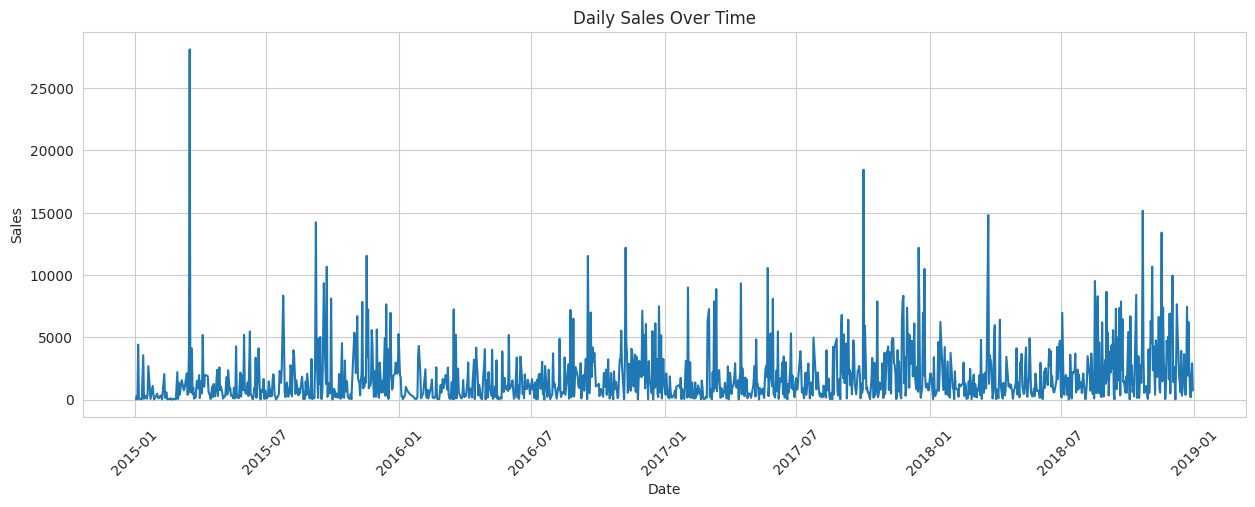

In [ ]:
# Group sales by date
df_daily = df.groupby('Order Date')['Sales'].sum().reset_index()

plt.figure(figsize=(15,5))
sns.lineplot(data=df_daily, x='Order Date', y='Sales')
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

STEP 7: Sales by Category and Region

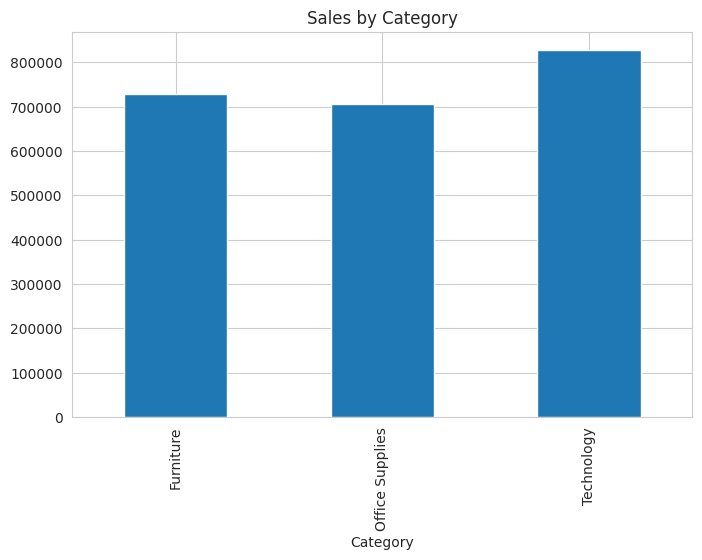

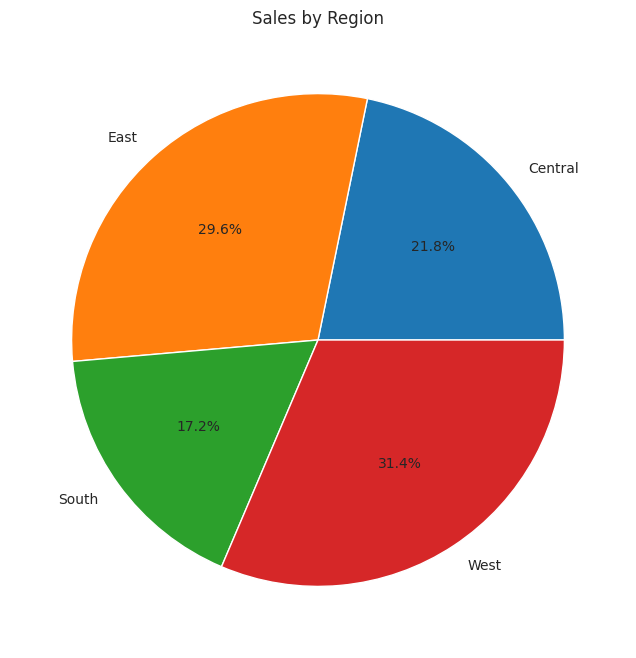

In [ ]:
# Category-wise sales
plt.figure(figsize=(8,5))
df.groupby('Category')['Sales'].sum().plot(kind='bar', title='Sales by Category')
plt.show()

# Region-wise sales
plt.figure(figsize=(8,8))
df.groupby('Region')['Sales'].sum().plot(kind='pie', autopct='%1.1f%%', title='Sales by Region')
plt.ylabel('')
plt.show()

STEP 8: Prepare Data for Time Series Forecasting

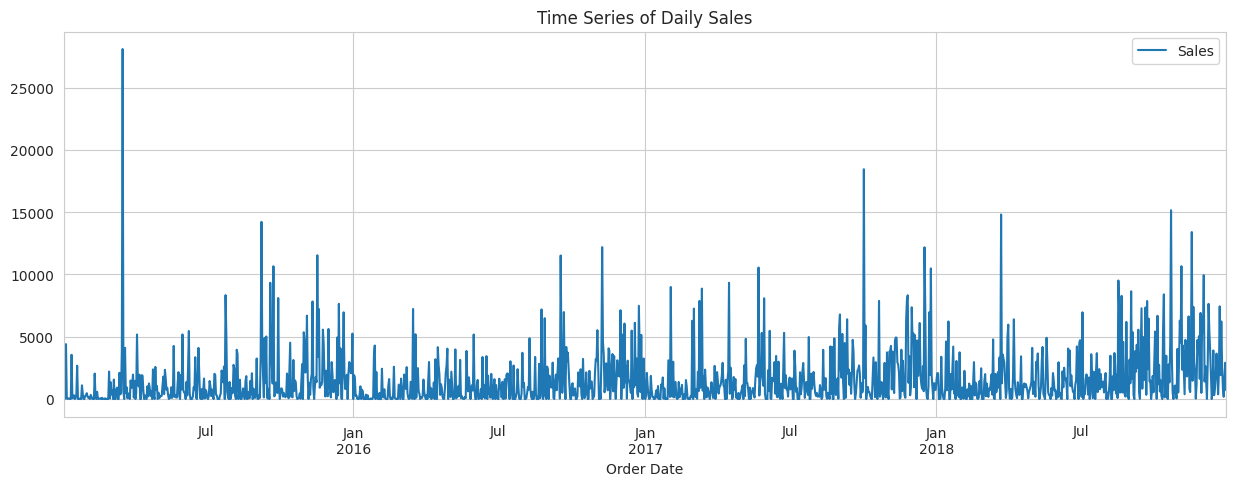

In [ ]:
df_ts = df.groupby('Order Date')['Sales'].sum().reset_index()
df_ts = df_ts.set_index('Order Date')
df_ts = df_ts.asfreq('D')  # daily frequency
df_ts = df_ts.fillna(0)    # fill missing days with 0
df_ts.plot(figsize=(15, 5), title="Time Series of Daily Sales")
plt.show()

STEP 9: Build ARIMA Model for Forecasting

In [ ]:
# Fit ARIMA model (you can tune (p,d,q) values later)
model = ARIMA(df_ts, order=(5, 1, 0))
model_fit = model.fit()


STEP 10: Forecast Next 7 Days

In [ ]:
forecast = model_fit.forecast(steps=7)

# Create forecast DataFrame with dates
last_date = df_ts.index[-1]
forecast_dates = [last_date + timedelta(days=i) for i in range(1, 8)]
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Predicted Sales': forecast.values})

# Display forecast
print("Sales Forecast for Next 7 Days:")
print(forecast_df)


Sales Forecast for Next 7 Days:
        Date  Predicted Sales
0 2018-12-31      1611.896026
1 2019-01-01      1357.846283
2 2019-01-02      1267.973100
3 2019-01-03      1494.626428
4 2019-01-04      1715.337293
5 2019-01-05      1319.613596
6 2019-01-06      1474.782810


STEP 11: Plot the Forecast

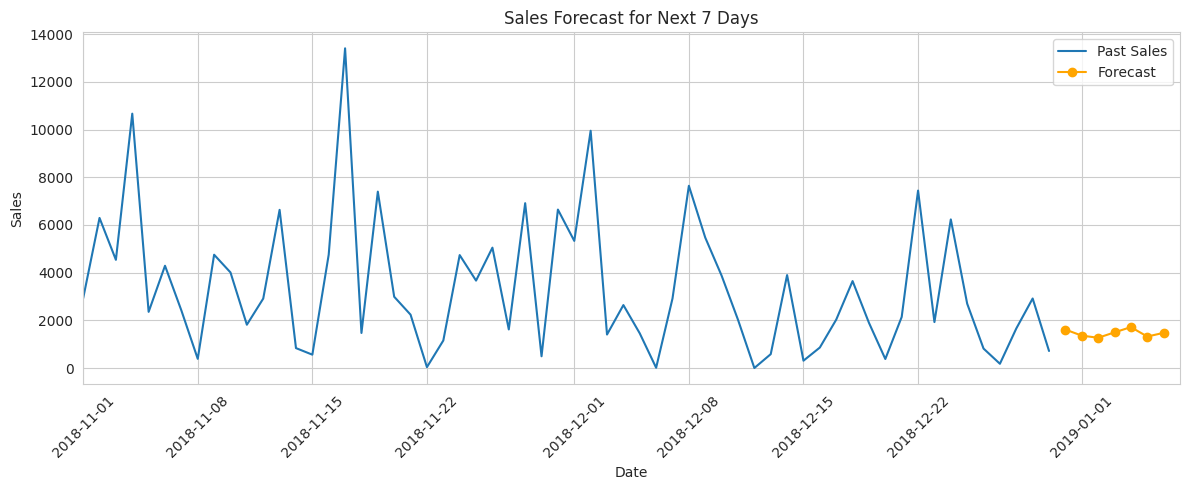

In [ ]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df_ts.index[-60:], df_ts['Sales'][-60:], label='Past Sales')
plt.plot(forecast_df['Date'], forecast_df['Predicted Sales'], label='Forecast', marker='o', color='orange')

# Title and labels
plt.title("Sales Forecast for Next 7 Days")
plt.xlabel("Date")
plt.ylabel("Sales")

# Set x-axis range to focus on last few days + forecast
min_date = df_ts.index[-60]
max_date = forecast_df['Date'].max()  # Last forecasted date
plt.xlim(min_date, max_date + pd.Timedelta(days=1))  # extend to show all points

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
